In [ ]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

MODEL_PATH = "best_yolo.pt"
MARGIN = 5
OUTPUT_DIR = "patient_reports"

os.makedirs(OUTPUT_DIR, exist_ok=True)

model = YOLO(MODEL_PATH)

def normalize_to_png(img):
    img = img.astype(np.float32)
    if img.max() == img.min():
        return np.zeros_like(img, dtype=np.uint8)
    return ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)


def tight_crop(img, mask, label, margin):
    y, x = np.where(mask == label)
    if len(y) == 0:
        return None, None

    y1 = max(y.min() - margin, 0)
    y2 = min(y.max() + margin, img.shape[0] - 1)
    x1 = max(x.min() - margin, 0)
    x2 = min(x.max() + margin, img.shape[1] - 1)

    return img[y1:y2+1, x1:x2+1], mask[y1:y2+1, x1:x2+1]


def compute_metrics(mask_bool, spacing):
    y, x = np.where(mask_bool)
    if len(y) == 0:
        return None, None, None

    height_px = y.max() - y.min()
    depth_px = x.max() - x.min()

    height_mm = height_px * spacing[1]
    depth_mm = depth_px * spacing[0]

    height_index = height_mm / depth_mm if depth_mm > 0 else None
    height_to_depth = height_mm / depth_mm if depth_mm > 0 else None

    return height_mm, height_index, height_to_depth


def show_sagittal_with_discs_full(img, mask):
    plt.figure(figsize=(8, 12))
    plt.imshow(img, cmap="gray")

    colors = {
        201: (1, 0, 0),
        202: (0, 1, 0),
        203: (0, 0, 1),
        204: (1, 1, 0),
        205: (1, 0, 1)
    }

    for label, color in colors.items():
        disc_mask = mask == label
        if np.any(disc_mask):
            overlay = np.zeros((*disc_mask.shape, 4))
            overlay[..., :3] = color
            overlay[..., 3] = disc_mask * 0.35
            plt.imshow(overlay)

    plt.title("Full sagittal spine slice with disc masks")
    plt.axis("off")
    plt.show()


def analyze_disc_and_save_csv(image_mha, mask_mha, patient_number=None, show_visualization=True):
    img = sitk.ReadImage(image_mha)
    mask = sitk.ReadImage(mask_mha)

    orient = sitk.DICOMOrientImageFilter()
    orient.SetDesiredCoordinateOrientation("LPS")
    img = orient.Execute(img)
    mask = orient.Execute(mask)

    spacing = img.GetSpacing()
    arr_img = sitk.GetArrayFromImage(img)
    arr_mask = sitk.GetArrayFromImage(mask)

    mask_slices = np.any(arr_mask > 0, axis=1)
    x_indices = np.where(mask_slices.any(axis=0))[0]
    if len(x_indices) == 0:
        raise ValueError("No discs found in mask")

    x_center = int(np.mean(x_indices))
    slice_img = np.flipud(arr_img[:, :, x_center])
    slice_mask = np.flipud(arr_mask[:, :, x_center])

    if show_visualization:
        show_sagittal_with_discs_full(slice_img, slice_mask)

    report = []
    for disc_label in range(201, 206):
        crop_img, crop_mask = tight_crop(slice_img, slice_mask, disc_label, MARGIN)
        if crop_img is None:
            continue

        png = normalize_to_png(crop_img)
        pred = model.predict(png, verbose=False)[0].probs.top1 + 1

        height_mm, height_index, height_to_depth = compute_metrics(
            crop_mask == disc_label, spacing
        )

        report.append({
            "disc_level": disc_label - 200,
            "pfirrmann_pred": int(pred),
            "disc_height_mm": height_mm,
            "height_index": height_index,
            "height_to_depth_ratio": height_to_depth
        })

    df_report = pd.DataFrame(report)

    if patient_number is None:
        patient_number = os.path.basename(image_mha).split("_")[0]

    csv_path = os.path.join(OUTPUT_DIR, f"{patient_number}_patient_report.csv")
    df_report.to_csv(csv_path, index=False)
    print(f"Saved report to {csv_path}")

    return df_report

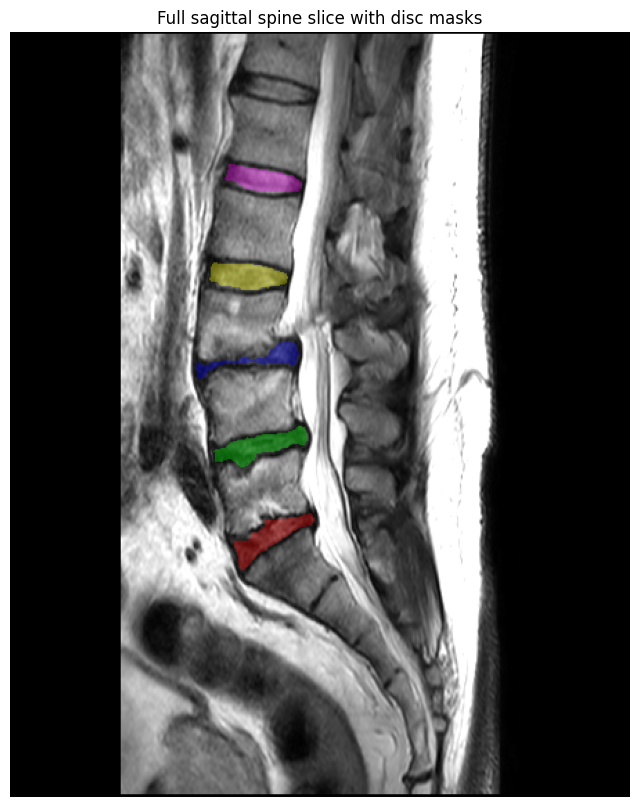

Saved report to patient_reports/4_patient_report.csv


,disc_level,pfirrmann_pred,disc_height_mm,height_index,height_to_depth_ratio
0,1,3,25.624985,0.135425,0.135425
1,2,3,18.124990,0.081492,0.081492
2,3,5,16.249991,0.066150,0.066150
3,4,2,11.874993,0.063879,0.063879
4,5,1,11.874993,0.065040,0.065040


In [19]:
df_report = analyze_disc_and_save_csv(
    "SPIDER_cleaned/images/4_t2.mha",
    "SPIDER_cleaned/masks/4_t2.mha", 4
)

df_report